# Clifford attractors


<img align='right' style='padding:30px 0px 40px 20px' 
src='./assets/clifford_screenshot.png'/>


[Clifford attractors](attractors.py) are a type of iterative equation that traces the path of a particle through a 2D space using functions of sine and cosine terms that make interesting "attractor" patterns (covering only some portions of the possible space, in certain shapes). 

Here we use Numpy and Pandas to calculate a dataframe consisting of millions of such locations, using [Numba](https://numba.pydata.org) to make generating them 50X faster than bare Python. We'll then plot the results as a static image using [Datashader](https://datashader.org), which renders arbitrarily large data into fixed-sized images.

In [1]:
import numpy as np
from numba import jit

@jit
def clifford_trajectory(a, b, c, d, x0, y0, n):
    xs, ys = np.zeros(n), np.zeros(n)
    xs[0], ys[0] = x0, y0
    for i in np.arange(n-1):
        xs[i+1] = np.sin(a * ys[i]) + c * np.cos(a * xs[i])
        ys[i+1] = np.sin(b * xs[i]) + d * np.cos(b * ys[i])
    return xs, ys

We can visualize the resulting dataframe using [Datashader](https://datashader.org), with colormaps from [Colorcet](https://colorcet.holoviz.org):

In [2]:
import datashader as ds, pandas as pd
from colorcet import palette_n as ps

def clifford_plot(a=1.9, b=1.9, c=1.9, d=0.8, n=1000000, colormap=ps['kbc']):
    cvs = ds.Canvas(plot_width=600, plot_height=600)
    xs, ys = clifford_trajectory(a, b, c, d, 0, 0, n)
    agg = cvs.points(pd.DataFrame({'x':xs, 'y':ys}), 'x', 'y')
    return ds.tf.shade(agg, cmap=colormap[::-1])

/home/runner/work/examples/examples/attractors/envs/default/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


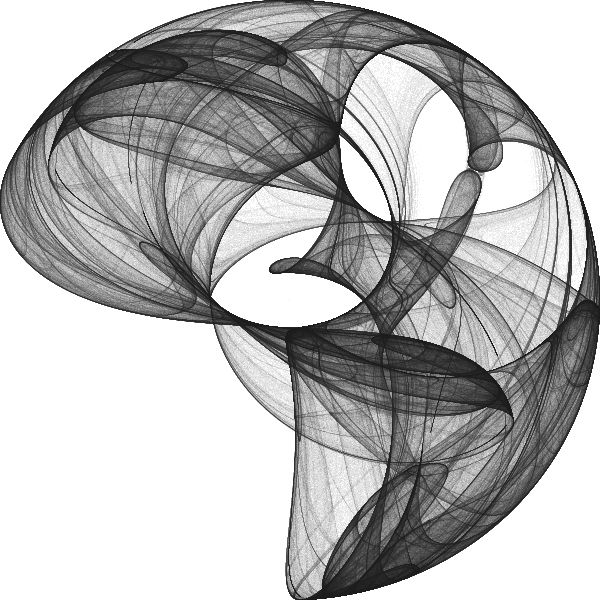

In [3]:
clifford_plot(a=1.7, b=1.7, c=0.6, d=1.2, n=20000000, colormap=ps['dimgray'])

Twenty million data points from an attractor clearly makes an interesting shape! The shapes depend on the parameters provided, and we can now easily build a control panel for exploring the effect of those parameters, using interactive widgets from [Panel](https://panel.holoviz.org):

Column
    [0] FloatSlider(end=2.0, name='a', value=1.9)
    [1] FloatSlider(end=2.0, name='b', value=1.9)
    [2] FloatSlider(end=2.0, name='c', value=1.9)
    [3] FloatSlider(name='d', value=0.8)
    [4] IntSlider(end=20000000, name='n', start=1000, step=100, value=10000000)
    [5] Select(name='colormap', options=AttrODict([('bgy', ...]), value=['#000458', '#00055a', ...])
    [6] ParamFunction(function, _pane=PNG, defer_load=False)
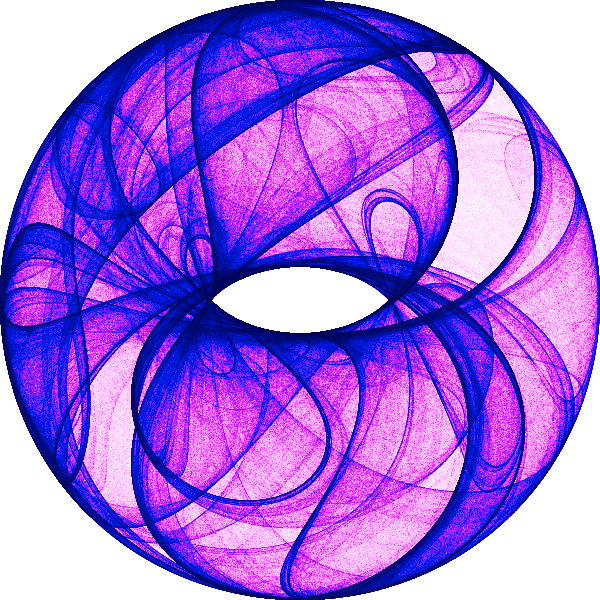

In [4]:
import panel as pn
pn.extension()

widgets = {
    'a': pn.widgets.FloatSlider(value=1.9, end=2.0, step=0.1, name='a'),
    'b': pn.widgets.FloatSlider(value=1.9, end=2.0, step=0.1, name='b'),
    'c': pn.widgets.FloatSlider(value=1.9, end=2.0, step=0.1, name='c'),
    'd': pn.widgets.FloatSlider(value=0.8, end=1.0, step=0.1, name='d'),
    'n': pn.widgets.IntSlider(value=10000000, start=1000, end=20000000, step=100, name='n'),
    'colormap': pn.widgets.Select(value=ps['bmw'], options=ps, name='colormap'),
}

bound_clifford_plot = pn.bind(clifford_plot, **widgets)
pn.Column(*widgets.values(), bound_clifford_plot)

Here `bind()` enables you to build interactive components that respond to user inputs simply by binding widgets to functions. This lets us vary the arguments to the given function interactively by changing the widget values and see the results, as long as this notebook is backed by a live, running Python process.

Our next step involves creating a panel dashboard, offering easy deployment and sharing for our application. To achieve this, we'll assemble the widgets into a structured column format, accompanied by a logo image and explanatory Markdown text, to explain how to use the dashboard effectively. Then, we'll integrate this column into a simple template, serving the output within a user-friendly dashboard interface:

In [5]:
logo = "https://tinyurl.com/y9c2zn65/logo_stacked_s.png"

text = ''' **Use the widgets to vary the parameters of this [Clifford attractor](https://examples.holoviz.org/gallery/attractors/attractors.html).** 
 
 **Note that many values result in nearly blank plots that contain only a few scattered points.**'''

template = pn.template.BootstrapTemplate(
    header_background='#9944DA',
    title='Clifford Attractor',
    sidebar=[logo, text, *widgets.values()],
    main=[pn.panel(bound_clifford_plot, sizing_mode='stretch_width')]
)
template.servable();

You can add `.show()` after `.servable()` if you want to launch a standalone dashboard immediately from within the Jupyter notebook, or just run this notebook through Bokeh Server using `panel serve --show clifford_panel.ipynb`, your browser will open a separate window with the serveable object ready to explore or share, just like the screenshot at the top of this notebook.

So it's your choice -- use a static Image in a Jupyter cell, make it an interactive app using Panel's `bind`, or very easily reconfigure it into a shareable, deployable dashboard!